In [261]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn import utils

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [7]:
tsla_data=pd.read_csv('TSLA.csv',sep=',',header=0)
googl_data=pd.read_csv('GOOGL.csv',sep=',',header=0)
dji_data=pd.read_csv('DJI.csv',sep=',',header=0)


In [40]:
tsla_open=tsla_data['Open']
googl_open=googl_data['Open']
dji_open=dji_data['Open']

In [41]:
tsla_open=(np.reshape([tsla_open],[-1,1]))
googl_open=np.reshape([googl_open],[-1,1])
dji_open=np.reshape([dji_open],[-1,1])

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [43]:
#Tesla
tsla_scaler=MinMaxScaler()
tsla_scaler.fit(tsla_open)
tsla_open=tsla_scaler.transform(tsla_open)

#Google
googl_scaler=MinMaxScaler()
googl_scaler.fit(googl_open)
googl_open=googl_scaler.transform(googl_open)

#DOJ
dji_scaler=MinMaxScaler()
dji_scaler.fit(dji_open)
dji_open=dji_scaler.transform(dji_open)

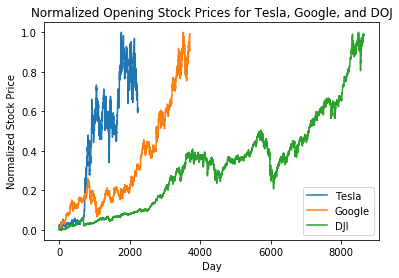

In [78]:
plt.plot(tsla_open)
plt.plot(googl_open)
plt.plot(dji_open)
plt.xlabel('Day')
plt.ylabel('Normalized Stock Price')
plt.title("Normalized Opening Stock Prices for Tesla, Google, and DOJ")
plt.legend(labels=('Tesla', 'Google','DJI'))

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [86]:
from scipy.linalg import hankel
from sklearn.model_selection import train_test_split

In [107]:
def split_data(company,size):
    new_data=hankel(company[0:size],company[size:])
    x=new_data[0:-1]
    y=new_data[-1]
    x=np.transpose(x)
    return x,y
    
    

In [108]:
tsla_x,tsla_y=split_data(tsla_open,31)
google_x,google_y=split_data(googl_open,31)
dji_x,dji_y=split_data(dji_open,31)

In [109]:
np.shape(tsla_y)

(2196,)

In [110]:
def train_test_val(x,y):
    train_x,total_x,train_y,total_y=train_test_split(x,y,test_size=.2,shuffle=False,stratify=None)
    val_x,test_x,val_y,test_y=train_test_split(x,y,test_size=.5,shuffle=False,stratify=None)
    return train_x,train_y,val_x,val_y,test_x,test_y

In [111]:
t_train_x,t_train_y,t_val_x,t_val_y,t_test_x,t_test_y=train_test_val(tsla_x,tsla_y)
g_train_x,g_train_y,g_val_x,g_val_y,g_test_x,g_test_y=train_test_val(google_x,google_y)
d_train_x,d_train_y,d_val_x,d_val_y,d_test_x,d_test_y=train_test_val(dji_x,dji_y)

In [112]:
print(np.shape(t_train_x))
print(np.shape(t_train_y))

(1756, 30)
(1756,)


In [199]:
p=t_train_x
r=np.transpose(p)
k=[r]
print(np.shape(k))

(1, 30, 1756)


In [356]:

def mini_batch(features,labels,mini_batch_size):
    """
    Args:
        features: features for one batch
        labels: labels for one batch
        mini_batch_size: the mini-batch size you want to use.
    Hint: Use "yield" to generate mini-batch features and labels
    """
    #batch size is number of samples in each iteration 
    features,labels=utils.shuffle(features,labels)
    data_size=np.shape(labels)[0]
    its=data_size//mini_batch_size
    i=0
    j=mini_batch_size
    k=0
    while k != its:
        mb_features=features[i:j]
        mb_labels=labels[i:j]
        i+=mini_batch_size
        j+=mini_batch_size
        k+=1
        yield mb_features, mb_labels
        

# TesnorFlow Model

In [408]:
tf.reset_default_graph()

In [409]:
n_neurons=100
lr=.001
batch_size=128
num_seq=30
input_size=1
n_outputs=1
X = tf.placeholder(tf.float32,[None,num_seq,input_size],name='X')
Y = tf.placeholder(tf.float32,[None,n_outputs],name='Y')
# X = tf.placeholder(tf.float32,[None,num_seq],name='X')
# Y = tf.placeholder(tf.float32,[None],name='Y')

In [410]:
# lstm_cell=tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
def GRU(x):
    GRU_cell=tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_units=n_neurons,activation=tf.nn.relu),output_size=n_outputs)
    outputs,states=tf.nn.dynamic_rnn(GRU_cell,inputs=x,dtype=tf.float32)
    return outputs[:,-1,:]

In [398]:
#tf.shape(outputs[:,-1,:])

In [411]:
#define loss
outputs=GRU(X)
loss = tf.reduce_mean(tf.square(outputs-Y),name='loss')
#define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
#correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
#accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')


# Training Tesla

In [400]:
import time
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(10):
        #fetch batch
        #acc=[]
        st=time.time()
        #for j in range(1,6):
        for (a,b) in mini_batch(t_train_x,t_train_y,128):
            batch_x, batch_y = np.expand_dims(a,-1), np.expand_dims(b,-1)
                #run optimization
            sess.run(train_op, feed_dict={X:batch_x, Y:batch_y}) 
            lo=sess.run(loss,feed_dict={X:batch_x, Y:batch_y})
            #acc.append( sess.run(accuracy,feed_dict={X:batch_x, Y:batch_y}))
        mid=time.time()
        print("Epoch "+str(i)+", Time:{} ".format(mid-st)+", Loss= {:.3f}".format(lo))
        
        batch_a,batch_b=np.expand_dims(t_val_x,-1),np.expand_dims(t_val_y,-1)
        #batch_a=load_cifar_template1.features_reshape(batch_a)
        #val=sess.run(accuracy, feed_dict={X:batch_a, Y:batch_b})
        #print("Validation Accuracy:",val)
    
    print("Training finished!")
    testing=[]
#     for (a,b) in load_preprocessed_test_batch(128):
#         batch_x, batch_y = a, b
    batch_a=np.expand_dims(t_test_x,-1)
    testing.append(sess.run(outputs, feed_dict={X:batch_a}))
    #print("Testing Accuracy: {:.3f}".format(np.average(testing)))

Epoch 0, Time:2.491877794265747 , Loss= 0.034
Epoch 1, Time:2.019260883331299 , Loss= 0.002
Epoch 2, Time:2.240447998046875 , Loss= 0.002
Epoch 3, Time:2.1544342041015625 , Loss= 0.001
Epoch 4, Time:2.137115478515625 , Loss= 0.001
Epoch 5, Time:2.010659694671631 , Loss= 0.001
Epoch 6, Time:1.9640698432922363 , Loss= 0.000
Epoch 7, Time:1.7749218940734863 , Loss= 0.001
Epoch 8, Time:1.6699726581573486 , Loss= 0.000
Epoch 9, Time:1.7733006477355957 , Loss= 0.000
Training finished!


Text(0.5,1,'Predicted and Actual')

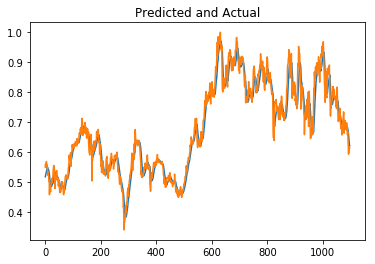

In [407]:
plt.plot(np.squeeze(testing))
plt.plot(t_test_y)
plt.title("Predicted and Actual")

This below is what I got when I did it the other way(I feed my prediction through), but then I accidently deleted the code for that so I just won't touch this.

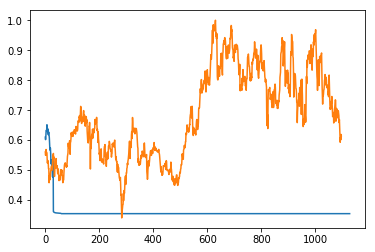

In [394]:
plt.plot(batch_a)
plt.plot(t_test_y[1:])

# Training Google

In [412]:
import time
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(10):
        #fetch batch
        #acc=[]
        st=time.time()
        #for j in range(1,6):
        for (a,b) in mini_batch(g_train_x,g_train_y,128):
            batch_x, batch_y = np.expand_dims(a,-1), np.expand_dims(b,-1)
                #run optimization
            sess.run(train_op, feed_dict={X:batch_x, Y:batch_y}) 
            lo=sess.run(loss,feed_dict={X:batch_x, Y:batch_y})
            #acc.append( sess.run(accuracy,feed_dict={X:batch_x, Y:batch_y}))
        mid=time.time()
        print("Epoch "+str(i)+", Time:{} ".format(mid-st)+", Loss= {:.3f}".format(lo))
        
        batch_a,batch_b=np.expand_dims(g_val_x,-1),np.expand_dims(g_val_y,-1)
        #batch_a=load_cifar_template1.features_reshape(batch_a)
        #val=sess.run(accuracy, feed_dict={X:batch_a, Y:batch_b})
        #print("Validation Accuracy:",val)
    
    print("Training finished!")
    testing=[]
#     for (a,b) in load_preprocessed_test_batch(128):
#         batch_x, batch_y = a, b
    batch_a=np.expand_dims(g_test_x,-1)
    testing.append(sess.run(outputs, feed_dict={X:batch_a}))
    #print("Testing Accuracy: {:.3f}".format(np.average(testing)))

Epoch 0, Time:3.04819917678833 , Loss= 0.007
Epoch 1, Time:2.609318971633911 , Loss= 0.001
Epoch 2, Time:2.6148324012756348 , Loss= 0.000
Epoch 3, Time:2.7071609497070312 , Loss= 0.000
Epoch 4, Time:2.651642084121704 , Loss= 0.000
Epoch 5, Time:2.728598117828369 , Loss= 0.000
Epoch 6, Time:2.5595595836639404 , Loss= 0.000
Epoch 7, Time:2.41628360748291 , Loss= 0.000
Epoch 8, Time:2.56229305267334 , Loss= 0.000
Epoch 9, Time:2.55265474319458 , Loss= 0.000
Training finished!


Text(0.5,1,'Predicted and Actual Google')

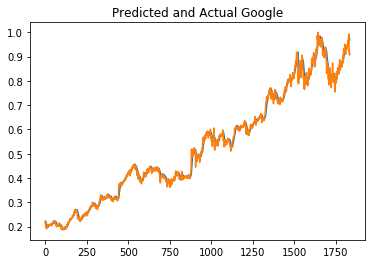

In [413]:
plt.plot(np.squeeze(testing))
plt.plot(g_test_y)
plt.title("Predicted and Actual Google")

# DOW Training

In [414]:
import time
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(10):
        #fetch batch
        #acc=[]
        st=time.time()
        #for j in range(1,6):
        for (a,b) in mini_batch(d_train_x,d_train_y,128):
            batch_x, batch_y = np.expand_dims(a,-1), np.expand_dims(b,-1)
                #run optimization
            sess.run(train_op, feed_dict={X:batch_x, Y:batch_y}) 
            lo=sess.run(loss,feed_dict={X:batch_x, Y:batch_y})
            #acc.append( sess.run(accuracy,feed_dict={X:batch_x, Y:batch_y}))
        mid=time.time()
        print("Epoch "+str(i)+", Time:{} ".format(mid-st)+", Loss= {:.3f}".format(lo))
        
        batch_a,batch_b=np.expand_dims(d_val_x,-1),np.expand_dims(d_val_y,-1)
        #batch_a=load_cifar_template1.features_reshape(batch_a)
        #val=sess.run(accuracy, feed_dict={X:batch_a, Y:batch_b})
        #print("Validation Accuracy:",val)
    
    print("Training finished!")
    testing=[]
#     for (a,b) in load_preprocessed_test_batch(128):
#         batch_x, batch_y = a, b
    batch_a=np.expand_dims(d_test_x,-1)
    testing.append(sess.run(outputs, feed_dict={X:batch_a}))
    #print("Testing Accuracy: {:.3f}".format(np.average(testing)))

Epoch 0, Time:6.528452157974243 , Loss= 0.000
Epoch 1, Time:6.299543857574463 , Loss= 0.000
Epoch 2, Time:6.52973484992981 , Loss= 0.000
Epoch 3, Time:6.269610643386841 , Loss= 0.000
Epoch 4, Time:6.13189959526062 , Loss= 0.000
Epoch 5, Time:6.341594696044922 , Loss= 0.000
Epoch 6, Time:4.781534671783447 , Loss= 0.000
Epoch 7, Time:5.218831777572632 , Loss= 0.000
Epoch 8, Time:6.442378282546997 , Loss= 0.000
Epoch 9, Time:6.82469916343689 , Loss= 0.000
Training finished!


Text(0.5,1,'Predicted and Actual DOW')

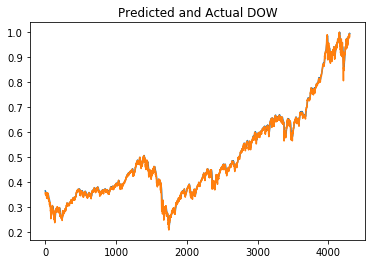

In [415]:
plt.plot(np.squeeze(testing))
plt.plot(d_test_y)
plt.title("Predicted and Actual DOW")